In [1]:
import os
import rioxarray as rxr
import xarray as xr
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import fiona
import earthpy.plot as ep
import rasterio
from affine import Affine
%matplotlib inline

In [2]:
snow_depth_xr = xr.open_dataset("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/era5-land_monthly_mean_sd_2001-2020.nc")
snow_cover_xr = xr.open_dataset("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/era5-land_monthly_mean_snowc_2001-2020.nc")
soil_h2o_xr = xr.open_dataset("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/era5-land_monthly_mean_swvl1_2001-2020.nc")
temp_2m_xr = xr.open_dataset("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/era5-land_monthly_mean_t2m_2001-2020.nc")

In [3]:
# Finding the correct index value for the time axis.
i = 0
for _ in snow_depth_xr.time.values:
    if str(_) == "2020-12-16T12:00:00.000000000":
        print(f"Done here is the index value for the above data is: {i}")
    i += 1

Done here is the index value for the above data is: 239


In [4]:
snow_depth_dec2020_xr = snow_depth_xr['sd'].isel(time=i-1)
snow_cover_dec2020_xr = snow_cover_xr['snowc'].isel(time=i-1)
soil_h2o_dec2020_xr = soil_h2o_xr['swvl1'].isel(time=i-1)
temp_2m_dec2020_xr = temp_2m_xr['t2m'].isel(time=i-1)

In [5]:
snow_depth_dec2020_xr

<xarray.DataArray 'sd' (latitude: 27, longitude: 93)>
array([[0.002249, 0.0023  , 0.002264, ..., 0.010148, 0.010214, 0.0105  ],
       [0.002344, 0.002371, 0.002467, ..., 0.009642, 0.009684, 0.009769],
       [0.002308, 0.002459, 0.002337, ..., 0.009099, 0.009104, 0.008867],
       ...,
       [0.000958, 0.001005, 0.001115, ..., 0.005982, 0.006344, 0.00673 ],
       [0.000973, 0.001027, 0.001142, ..., 0.006178, 0.006547, 0.007117],
       [0.000951, 0.001019, 0.001151, ..., 0.006366, 0.006828, 0.007366]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2020-12-16T12:00:00
  * latitude   (latitude) float32 53.1 53.0 52.9 52.8 ... 50.8 50.7 50.6 50.5
  * longitude  (longitude) float32 22.9 23.0 23.1 23.2 ... 31.8 31.9 32.0 32.1
Attributes:
    standard_name:  lwe_thickness_of_surface_snow_amount
    long_name:      Snow depth
    units:          m
    cell_methods:   time: mean
    grid_mapping:   latitude_longitude

In [6]:
snow_depth_dec2020_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/snow_depth_dec2020_xr.tif"
snow_cover_dec2020_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/snow_cover_dec2020_xr.tif"
soil_h2o_dec2020_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/soil_h2o_dec2020_xr.tif"
temp_2m_dec2020_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/ERA5-Land/monthly/mean/22.9E-32.1E_50.5N-53.1N/temp_2m_dec2020_xr.tif"

In [7]:
snow_depth_dec2020_xr.rio.to_raster(snow_depth_dec2020_path)
snow_cover_dec2020_xr.rio.to_raster(snow_cover_dec2020_path)
soil_h2o_dec2020_xr.rio.to_raster(soil_h2o_dec2020_path)
temp_2m_dec2020_xr.rio.to_raster(temp_2m_dec2020_path)

In [8]:
# Define a function to return the vertices of a polygon

def extract_vertices(shape_file_path):
    """Returns a numpy array of the lat/lons corresponding to the vertices of a polygon defined by a shape file.
    
    Keyword arguments:
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    
    Prerequisites: 
    - fiona
    - numpy
    """
    
    # Extract the vertices using fiona
    with fiona.open(shape_file_path) as shape_data:
        vertices = shape_data[0]['geometry']['coordinates'][0]
        
    # Return them as a numpy array
    return np.array(vertices)

In [9]:
# Define a function to do the cropping of the data

def crop_data_spatially(input_data, shape_file_path, zero_remap = np.nan):
    """Crops input data to keep only the elements within the spatial bounds defined by the input shape file.
    
    Keyword arguments:
    input_data -- DataArray of input data and corresponding x/y (latitude/longitude) coordinates
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    zero_remap -- the new value that elements outside the spatial bounds (but not dropped from the output DataArray)
                  are mapped to after the crop has occurred
                  
    Prerequisites:
    - rioxarray
    """
    
    # Check that zero_remap is the same type as the values in input_data
    try:
        if not ((isinstance(zero_remap, (int, np.integer)) and isinstance(input_data.values[0,0,0], (int, np.integer))) or
                 (isinstance(zero_remap, (float, np.float64)) and isinstance(input_data.values[0,0,0], (float, np.float64)))):
            raise TypeError('The zero_remap value provided must match the type of the input data:', type(zero_remap), type(input_data.values.dtype)) 
    
    except TypeError as error:
        print(error.args)
    
    
    # Extract the vertice's latitude/longitudes from the shape file
    vertices = extract_vertices(shape_file_path) 
    
    # Define a geometry object to define the polygon
    shape_geometry = [{'type': 'Polygon',
                       'coordinates': [vertices]}]
    
    # Crop the data using the latitude/longitudes and remap the new zero values 
    data_cropped = (input_data-zero_remap).rio.clip(shape_geometry, "epsg:4326") + zero_remap
    return data_cropped

In [10]:
snow_depth_dec2020_xr = rxr.open_rasterio(snow_depth_dec2020_path)
snow_cover_dec2020_xr = rxr.open_rasterio(snow_cover_dec2020_path)
soil_h2o_dec2020_xr = rxr.open_rasterio(soil_h2o_dec2020_path)
temp_2m_dec2020_xr = rxr.open_rasterio(temp_2m_dec2020_path)

In [11]:
# Just some usual info you can print
print("The crs of your data is:", snow_depth_dec2020_xr.rio.crs)
print("The shape of your data is:", snow_depth_dec2020_xr.shape)
print("The metadata for your data is:", snow_depth_dec2020_xr.attrs)

The crs of your data is: None
The shape of your data is: (1, 27, 93)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'Snow depth'}


In [12]:
snow_depth_dec2020_xr = snow_depth_dec2020_xr.rio.write_crs(4326)
snow_cover_dec2020_xr = snow_cover_dec2020_xr.rio.write_crs(4326)
soil_h2o_dec2020_xr = soil_h2o_dec2020_xr.rio.write_crs(4326)
temp_2m_dec2020_xr = temp_2m_dec2020_xr.rio.write_crs(4326)

In [13]:
snow_depth_dec2020_clipped_xr = crop_data_spatially(snow_depth_dec2020_xr, "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/area_of_interest/whole_map.shp", -2)
snow_cover_dec2020_clipped_xr = crop_data_spatially(snow_cover_dec2020_xr, "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/area_of_interest/whole_map.shp", -2)
soil_h2o_dec2020_clipped_xr = crop_data_spatially(soil_h2o_dec2020_xr, "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/area_of_interest/whole_map.shp", -2)
temp_2m_dec2020_clipped_xr = crop_data_spatially(temp_2m_dec2020_xr, "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/area_of_interest/whole_map.shp", -2)

('The zero_remap value provided must match the type of the input data:', <class 'int'>, <class 'numpy.dtype[float32]'>)
('The zero_remap value provided must match the type of the input data:', <class 'int'>, <class 'numpy.dtype[float32]'>)
('The zero_remap value provided must match the type of the input data:', <class 'int'>, <class 'numpy.dtype[float32]'>)
('The zero_remap value provided must match the type of the input data:', <class 'int'>, <class 'numpy.dtype[float32]'>)


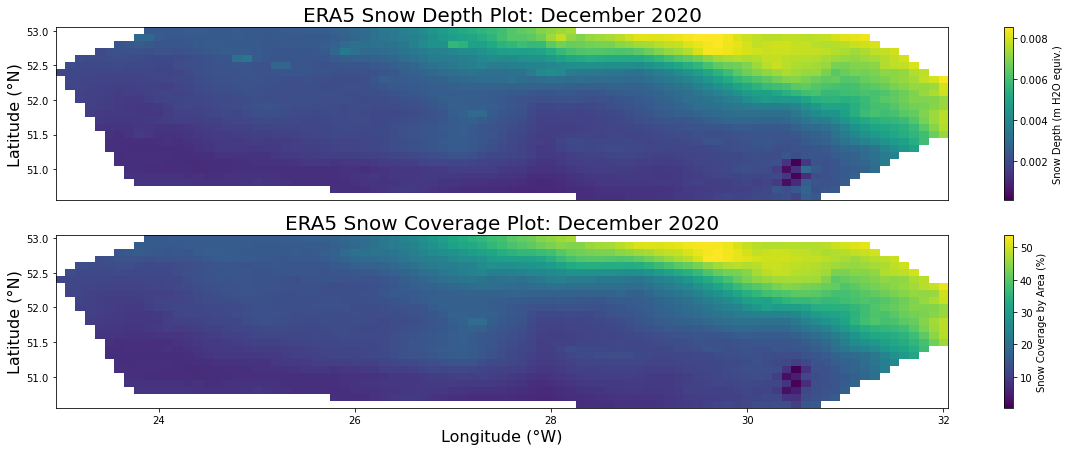

In [14]:
plt.close("all")
fig, ax = plt.subplots(2, figsize=(20,7))
snow_depth_dec2020_clipped_xr.plot(ax=ax[0], cbar_kwargs={'label': 'Snow Depth (m H2O equiv.)'});
ax[0].set_title('ERA5 Snow Depth Plot: December 2020',fontsize=20);
ax[0].axes.xaxis.set_visible(False)
ax[0].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);
snow_cover_dec2020_clipped_xr.plot(ax=ax[1], cbar_kwargs={'label': 'Snow Coverage by Area (%)'});
ax[1].set_title('ERA5 Snow Coverage Plot: December 2020',fontsize=20);
ax[1].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax[1].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

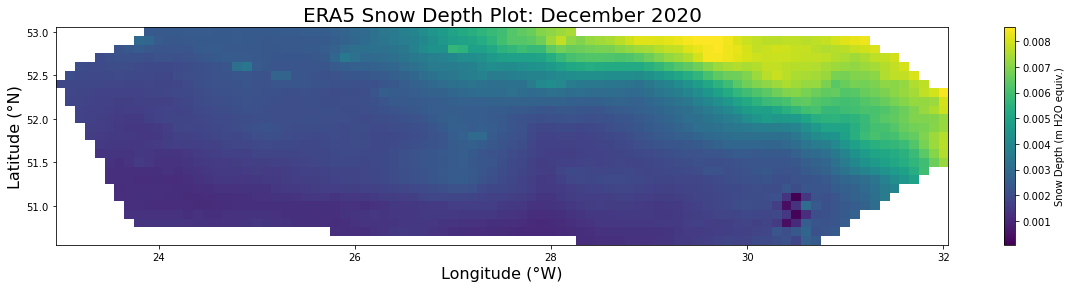

In [15]:
plt.close("all")
fig, ax = plt.subplots(figsize=(20,4))
snow_depth_dec2020_clipped_xr.plot(ax=ax, cbar_kwargs={'label': 'Snow Depth (m H2O equiv.)'});
ax.set_title('ERA5 Snow Depth Plot: December 2020',fontsize=20);
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

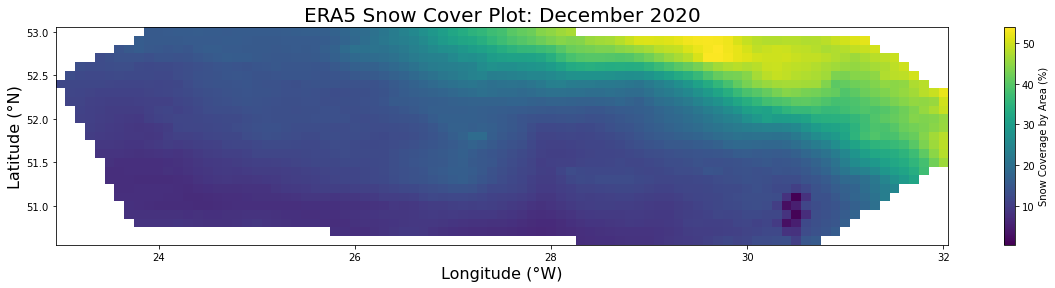

In [16]:
plt.close("all")
fig, ax = plt.subplots(figsize=(20,4))
snow_cover_dec2020_clipped_xr.plot(ax=ax, cbar_kwargs={'label': 'Snow Coverage by Area (%)'});
ax.set_title('ERA5 Snow Cover Plot: December 2020',fontsize=20);
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

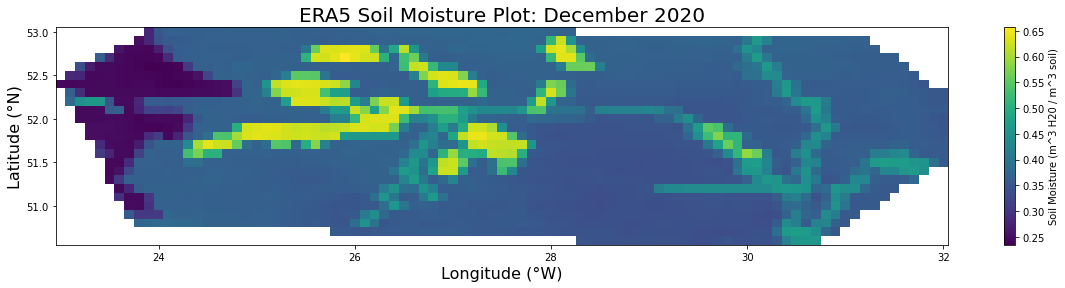

In [17]:
plt.close("all")
fig, ax = plt.subplots(figsize=(20,4))
soil_h2o_dec2020_clipped_xr.plot(ax=ax, cbar_kwargs={'label': 'Soil Moisture (m^3 H20 / m^3 soil)'});
ax.set_title('ERA5 Soil Moisture Plot: December 2020',fontsize=20);
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

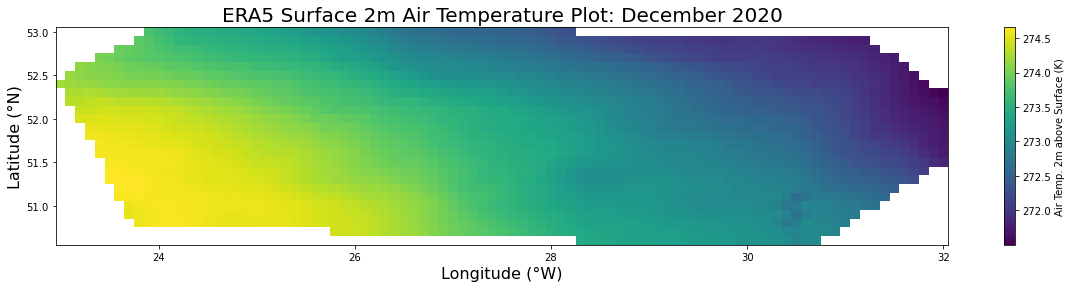

In [18]:
plt.close("all")
fig, ax = plt.subplots(figsize=(20,4))
temp_2m_dec2020_clipped_xr.plot(ax=ax, cbar_kwargs={'label': 'Air Temp. 2m above Surface (K)'});
ax.set_title('ERA5 Surface 2m Air Temperature Plot: December 2020',fontsize=20);
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);